### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Load the Data

In [2]:
df = pd.read_csv('../CombinedData/combined_player_stats.csv')

df.head()

,Date,Away Team,Home Team,Player,Player Team,Passing Yards,Passing TD,Passing INT,Receptions,Receiving Yards,Receiving TD,Rushing Yards,Rushing TD,Fumbles Lost
0,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Lamar Jackson,Baltimore Ravens,273,1,0,0,0,0,122,0,1
1,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Derrick Henry,Baltimore Ravens,0,0,0,0,0,0,46,1,0
2,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Zay Flowers,Baltimore Ravens,0,0,0,6,37,0,14,0,0
3,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Justice Hill,Baltimore Ravens,0,0,0,6,52,0,3,0,0
4,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Isaiah Likely,Baltimore Ravens,0,0,0,9,111,1,0,0,0


In [4]:
player_info = pd.read_csv('../CombinedData/PlayerInfo/All_NFL_Players_2024.csv', encoding='latin1')
player_info.head()

,Unnamed: 0,Unnamed: 1,Player,Pos,Team
0,Israel,Abanikanda,Israel Abanikanda,RB,San Francisco
1,Ameer,Abdullah,Ameer Abdullah,RB,Las Vegas
2,Yasir,Abdullah,Yasir Abdullah,LB,Jacksonville
3,Micah,Abernathy,Micah Abernathy,DB,Atlanta
4,Micah,Abraham,Micah Abraham,DB,Cincinnati


In [5]:
player_info.tail()

,Unnamed: 0,Unnamed: 1,Player,Pos,Team
2544,Ty,Zentner,Ty Zentner,P,Seattle
2545,Kilian,Zierer,Kilian Zierer,OT,Houston
2546,Zak,Zinter,Zak Zinter,OG,Cleveland
2547,Greg,Zuerlein,Greg Zuerlein,K,NY Jets
2548,Shane,Zylstra,Shane Zylstra,TE,Detroit


In [6]:
player_info = player_info[['Player', 'Pos']]

print(df.shape)
temp = pd.merge(df, player_info, on='Player', how='left')
print(temp.shape)

(3489, 14)
(3500, 15)


In [6]:
player_info.Player.value_counts()

Player
 Van                   7
Tyler Davis            2
Michael Carter         2
Brandon Smith          2
Byron Young            2
                      ..
Michael Hall           1
C.J. Ham               1
Arlington Hambright    1
Antonio Hamilton       1
Shane Zylstra          1
Name: count, Length: 2530, dtype: int64

### Clean Data

Better handling of duplicate names in player_info. We don't want duplicate rows in our data.

In [7]:
# not a great fix but it works
print(player_info.shape)
player_info = player_info[player_info['Pos'].isin(('QB', 'RB', 'WR', 'TE'))]
print(player_info.shape)

(2549, 2)
(768, 2)


In [8]:
print(player_info.Pos.value_counts())

WR    307
RB    181
TE    171
QB    109
Name: Pos, dtype: int64


In [9]:
print(df.shape)
df = pd.merge(df, player_info, on='Player', how='left')
print(df.shape)

(3489, 14)
(3489, 15)


### Add Fantasy Points to DF

In [10]:
df.head()

,Date,Away Team,Home Team,Player,Player Team,Passing Yards,Passing TD,Passing INT,Receptions,Receiving Yards,Receiving TD,Rushing Yards,Rushing TD,Fumbles Lost,Pos
0,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Lamar Jackson,Baltimore Ravens,273,1,0,0,0,0,122,0,1,QB
1,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Derrick Henry,Baltimore Ravens,0,0,0,0,0,0,46,1,0,RB
2,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Zay Flowers,Baltimore Ravens,0,0,0,6,37,0,14,0,0,WR
3,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Justice Hill,Baltimore Ravens,0,0,0,6,52,0,3,0,0,RB
4,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Isaiah Likely,Baltimore Ravens,0,0,0,9,111,1,0,0,0,TE


In [11]:
points_per_passing_yard = 0.04
points_per_passing_td = 4
points_per_interception = -2
points_per_rushing_yard = 0.1
points_per_rushing_td = 6
points_per_reception = 1
points_per_receiving_yard = 0.1
points_per_receiving_td = 6
points_per_fumble = -2

def get_player_points(row):
    points = 0
    points += row['Passing Yards'] * points_per_passing_yard
    points += row['Passing TD'] * points_per_passing_td
    points += row['Passing INT'] * points_per_interception
    points += row['Rushing Yards'] * points_per_rushing_yard
    points += row['Rushing TD'] * points_per_rushing_td
    points += row['Receptions'] * points_per_reception
    points += row['Receiving Yards'] * points_per_receiving_yard
    points += row['Receiving TD'] * points_per_receiving_td
    points += row['Fumbles Lost'] * points_per_fumble

    return points

df['Fantasy Points'] = df.apply(get_player_points, axis=1)

df.head()

,Date,Away Team,Home Team,Player,Player Team,Passing Yards,Passing TD,Passing INT,Receptions,Receiving Yards,Receiving TD,Rushing Yards,Rushing TD,Fumbles Lost,Pos,Fantasy Points
0,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Lamar Jackson,Baltimore Ravens,273,1,0,0,0,0,122,0,1,QB,25.12
1,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Derrick Henry,Baltimore Ravens,0,0,0,0,0,0,46,1,0,RB,10.60
2,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Zay Flowers,Baltimore Ravens,0,0,0,6,37,0,14,0,0,WR,11.10
3,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Justice Hill,Baltimore Ravens,0,0,0,6,52,0,3,0,0,RB,11.50
4,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Isaiah Likely,Baltimore Ravens,0,0,0,9,111,1,0,0,0,TE,26.10


### Create the Feature we want to predict

In [12]:
df = df.sort_values(by='Date', ascending=True)

df[df['Player'] == 'Lamar Jackson']

,Date,Away Team,Home Team,Player,Player Team,Passing Yards,Passing TD,Passing INT,Receptions,Receiving Yards,Receiving TD,Rushing Yards,Rushing TD,Fumbles Lost,Pos,Fantasy Points
0,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Lamar Jackson,Baltimore Ravens,273,1,0,0,0,0,122,0,1,QB,25.12
426,2024-09-15,Las Vegas Raiders,Baltimore Ravens,Lamar Jackson,Baltimore Ravens,247,1,1,0,0,0,45,0,0,QB,16.38
638,2024-09-22,Baltimore Ravens,Dallas Cowboys,Lamar Jackson,Baltimore Ravens,182,1,0,0,0,0,87,1,0,QB,25.98
964,2024-09-29,Buffalo Bills,Baltimore Ravens,Lamar Jackson,Baltimore Ravens,156,2,0,0,0,0,54,1,1,QB,23.64
1264,2024-10-06,Baltimore Ravens,Cincinnati Bengals,Lamar Jackson,Baltimore Ravens,348,4,0,0,0,0,55,0,1,QB,33.42
1745,2024-10-13,Washington Commanders,Baltimore Ravens,Lamar Jackson,Baltimore Ravens,323,1,1,0,0,0,40,0,0,QB,18.92
2028,2024-10-21,Baltimore Ravens,Tampa Bay Buccaneers,Lamar Jackson,Baltimore Ravens,281,5,0,0,0,0,52,0,1,QB,34.44
2127,2024-10-27,Baltimore Ravens,Cleveland Browns,Lamar Jackson,Baltimore Ravens,289,2,0,0,0,0,46,0,0,QB,24.16
2464,2024-11-03,Denver Broncos,Baltimore Ravens,Lamar Jackson,Baltimore Ravens,280,3,0,0,0,0,4,0,0,QB,23.60
2701,2024-11-07,Cincinnati Bengals,Baltimore Ravens,Lamar Jackson,Baltimore Ravens,290,4,0,0,0,0,33,0,0,QB,30.90


In [13]:
df['Next Week Fantasy Points'] = df.groupby('Player')['Fantasy Points'].shift(-1)

df[df['Player'] == 'Lamar Jackson']

,Date,Away Team,Home Team,Player,Player Team,Passing Yards,Passing TD,Passing INT,Receptions,Receiving Yards,Receiving TD,Rushing Yards,Rushing TD,Fumbles Lost,Pos,Fantasy Points,Next Week Fantasy Points
0,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Lamar Jackson,Baltimore Ravens,273,1,0,0,0,0,122,0,1,QB,25.12,16.38
426,2024-09-15,Las Vegas Raiders,Baltimore Ravens,Lamar Jackson,Baltimore Ravens,247,1,1,0,0,0,45,0,0,QB,16.38,25.98
638,2024-09-22,Baltimore Ravens,Dallas Cowboys,Lamar Jackson,Baltimore Ravens,182,1,0,0,0,0,87,1,0,QB,25.98,23.64
964,2024-09-29,Buffalo Bills,Baltimore Ravens,Lamar Jackson,Baltimore Ravens,156,2,0,0,0,0,54,1,1,QB,23.64,33.42
1264,2024-10-06,Baltimore Ravens,Cincinnati Bengals,Lamar Jackson,Baltimore Ravens,348,4,0,0,0,0,55,0,1,QB,33.42,18.92
1745,2024-10-13,Washington Commanders,Baltimore Ravens,Lamar Jackson,Baltimore Ravens,323,1,1,0,0,0,40,0,0,QB,18.92,34.44
2028,2024-10-21,Baltimore Ravens,Tampa Bay Buccaneers,Lamar Jackson,Baltimore Ravens,281,5,0,0,0,0,52,0,1,QB,34.44,24.16
2127,2024-10-27,Baltimore Ravens,Cleveland Browns,Lamar Jackson,Baltimore Ravens,289,2,0,0,0,0,46,0,0,QB,24.16,23.60
2464,2024-11-03,Denver Broncos,Baltimore Ravens,Lamar Jackson,Baltimore Ravens,280,3,0,0,0,0,4,0,0,QB,23.60,30.90
2701,2024-11-07,Cincinnati Bengals,Baltimore Ravens,Lamar Jackson,Baltimore Ravens,290,4,0,0,0,0,33,0,0,QB,30.90,14.88


### EDA

In [14]:
# look at the distribution of players by position
df.Pos.value_counts()

Pos
WR    1276
RB     839
TE     694
QB     419
Name: count, dtype: int64

<Axes: >

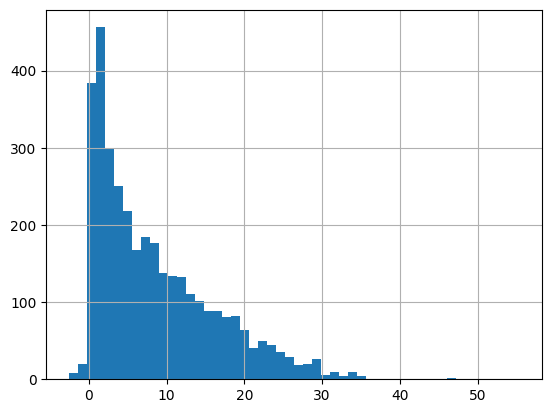

In [15]:
# look at the distribution of points
df['Fantasy Points'].hist(bins=50)

array([[<Axes: title={'center': 'QB'}>, <Axes: title={'center': 'RB'}>],
       [<Axes: title={'center': 'TE'}>, <Axes: title={'center': 'WR'}>]],
      dtype=object)

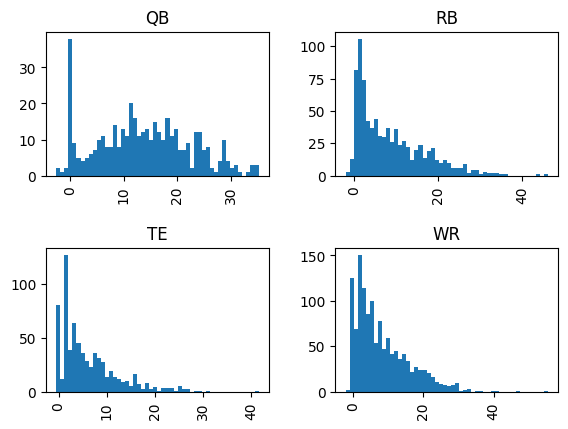

In [16]:
# break it down by pos
df['Fantasy Points'].hist(by=df['Pos'], bins=50)

In [17]:
df['Fantasy Points'].describe()

count    3489.00000
mean        8.48243
std         7.84363
min        -2.60000
25%         2.10000
50%         6.20000
75%        13.00000
max        55.40000
Name: Fantasy Points, dtype: float64

Let's look at some of our features against the target variable

In [14]:
# drop rows from the dataframe that have Nan values in the target column
print(df.shape)
df = df.dropna(subset=['Next Week Fantasy Points'])
print(df.shape)

(3489, 17)
(2946, 17)


In [15]:
qb = df[df['Pos'] == 'QB']
rb = df[df['Pos'] == 'RB']
wr = df[df['Pos'] == 'WR']
te = df[df['Pos'] == 'TE']

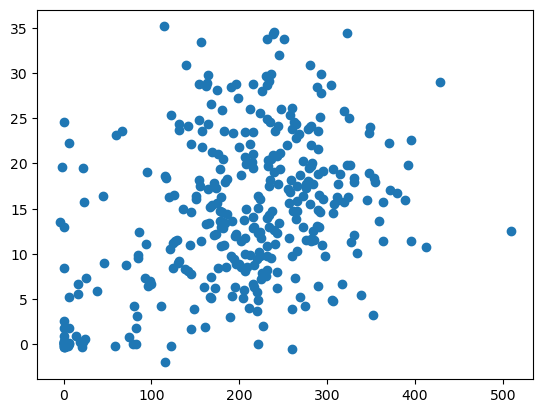

In [16]:
# plot passing yards vs fantasy points
plt.scatter(qb['Passing Yards'], qb['Next Week Fantasy Points'])

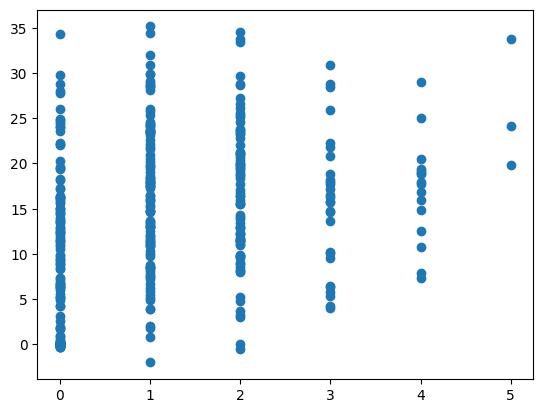

In [21]:
plt.scatter(qb['Passing TD'], qb['Next Week Fantasy Points'])

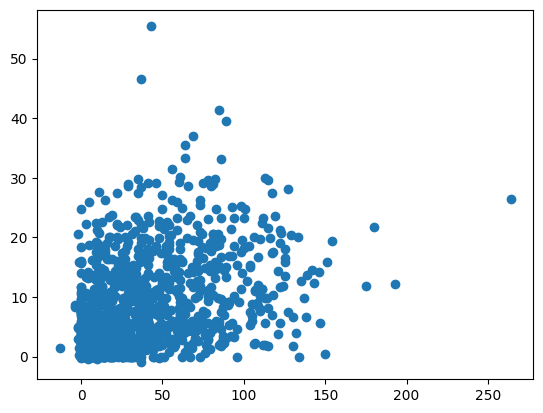

In [22]:
plt.scatter(wr['Receiving Yards'], wr['Next Week Fantasy Points'])

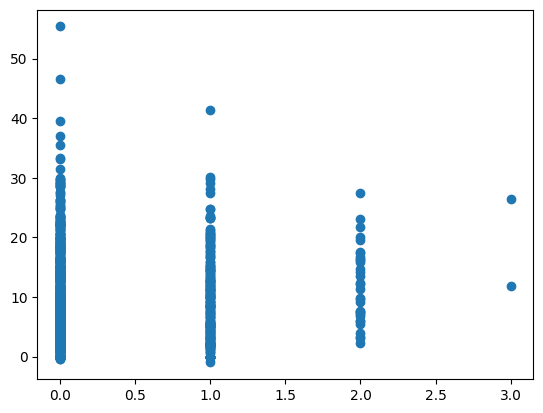

In [23]:
plt.scatter(wr['Receiving TD'], wr['Next Week Fantasy Points'])

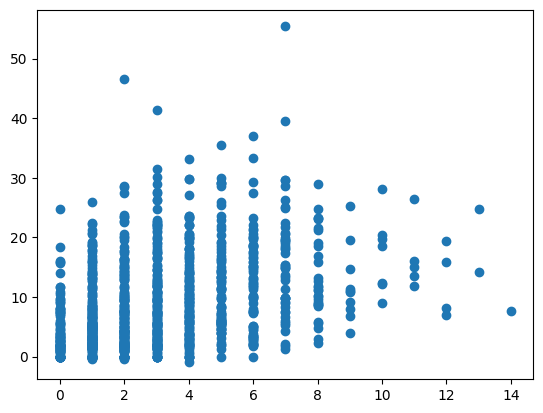

In [24]:
plt.scatter(wr['Receptions'], wr['Next Week Fantasy Points'])

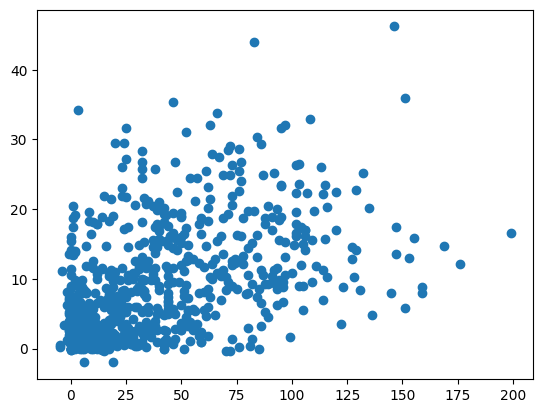

In [25]:
plt.scatter(rb['Rushing Yards'], rb['Next Week Fantasy Points'])

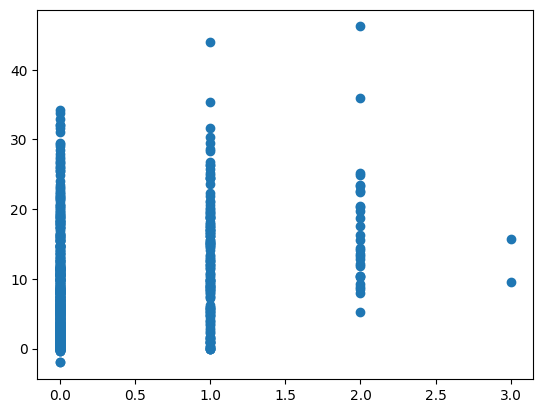

In [26]:
plt.scatter(rb['Rushing TD'], rb['Next Week Fantasy Points'])

### Create a Model

the following code will create a model for the qbs, however this could be applied to any of the positions

In [17]:
qb.head()

,Date,Away Team,Home Team,Player,Player Team,Passing Yards,Passing TD,Passing INT,Receptions,Receiving Yards,Receiving TD,Rushing Yards,Rushing TD,Fumbles Lost,Pos,Fantasy Points,Next Week Fantasy Points
0,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Lamar Jackson,Baltimore Ravens,273,1,0,0,0,0,122,0,1,QB,25.12,16.38
8,2024-09-05,Baltimore Ravens,Kansas City Chiefs,Patrick Mahomes,Kansas City Chiefs,291,1,1,1,2,0,3,0,0,QB,15.14,12.94
28,2024-09-06,Green Bay Packers,Philadelphia Eagles,Jalen Hurts,Philadelphia Eagles,278,2,2,0,0,0,33,0,1,QB,16.42,23.82
19,2024-09-06,Green Bay Packers,Philadelphia Eagles,Malik Willis,Green Bay Packers,0,0,0,0,0,0,0,0,0,QB,0.00,12.98
18,2024-09-06,Green Bay Packers,Philadelphia Eagles,Jordan Love,Green Bay Packers,260,2,1,0,0,0,0,0,0,QB,16.40,26.16


In [18]:
print(qb.shape)

(352, 17)


In [19]:
# we only want to keep columns that are going to be used as features in our model...  
# so we drop the columns that are not going to be used
qb = qb[['Passing Yards', 'Passing TD', 'Passing INT', 'Rushing Yards', 'Rushing TD', 'Fumbles Lost', 'Next Week Fantasy Points']]

qb.head()

,Passing Yards,Passing TD,Passing INT,Rushing Yards,Rushing TD,Fumbles Lost,Next Week Fantasy Points
0,273,1,0,122,0,1,16.38
8,291,1,1,3,0,0,12.94
28,278,2,2,33,0,1,23.82
19,0,0,0,0,0,0,12.98
18,260,2,1,0,0,0,26.16


In [20]:
X = qb.drop('Next Week Fantasy Points', axis=1)
y = qb[['Next Week Fantasy Points']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [21]:
model = xgb.XGBRegressor(objective ='reg:squarederror', seed=123)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [23]:
# evaluate on the test set
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('MSE: %.2f' % mse)

MSE: 92.54


### Look at some of the predictions and compare to actual values

In [33]:
X_test.head()

,Passing Yards,Passing TD,Passing INT,Rushing Yards,Rushing TD,Fumbles Lost
2048,349,0,0,8,0,0
2294,122,0,0,10,0,0
2116,330,3,2,11,0,0
180,317,1,1,0,0,0
46,232,2,0,39,2,1


In [24]:
# save model to json
model.save_model('QB_model.json')

In [34]:
# predict the next week fantasy points for the first 5 rows in the test set
model.predict(X_test.head())

array([11.381508 , 10.348116 , 12.709492 ,  5.9091277, 26.819305 ],
      dtype=float32)

In [35]:
# predict the next week fantasy points for the first 5 rows in the test set
predictions = model.predict(X_test.head())

# show the actual next week fantasy points for the first 5 rows in the test set
temp_df = y_test.head()
temp_df['predictions'] = predictions
temp_df['percent_difference'] = (temp_df['Next Week Fantasy Points'] - temp_df['predictions']) / temp_df['Next Week Fantasy Points']
temp_df

C:\Users\ruppea\AppData\Local\Temp\ipykernel_33292\2776431603.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['predictions'] = predictions
C:\Users\ruppea\AppData\Local\Temp\ipykernel_33292\2776431603.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['percent_difference'] = (temp_df['Next Week Fantasy Points'] - temp_df['predictions']) / temp_df['Next Week Fantasy Points']


,Next Week Fantasy Points,predictions,percent_difference
2048,24.06,11.381508,0.526953
2294,-0.20,10.348116,52.740580
2116,18.00,12.709492,0.293917
180,6.64,5.909128,0.110071
46,9.76,26.819305,-1.747880


In [36]:
df[(df['Passing Yards'] == 349) & (df['Rushing Yards'] == 8)]

,Date,Away Team,Home Team,Player,Player Team,Passing Yards,Passing TD,Passing INT,Receptions,Receiving Yards,Receiving TD,Rushing Yards,Rushing TD,Fumbles Lost,Pos,Fantasy Points,Next Week Fantasy Points
2048,2024-10-21,Los Angeles Chargers,Arizona Cardinals,Justin Herbert,Los Angeles Chargers,349,0,0,0,0,0,8,0,0,QB,14.76,24.06


In [37]:
df[(df['Passing Yards'] == 122) & (df['Rushing Yards'] == 10)]

,Date,Away Team,Home Team,Player,Player Team,Passing Yards,Passing TD,Passing INT,Receptions,Receiving Yards,Receiving TD,Rushing Yards,Rushing TD,Fumbles Lost,Pos,Fantasy Points,Next Week Fantasy Points
2294,2024-10-27,New Orleans Saints,Los Angeles Chargers,Jake Haener,New Orleans Saints,122,0,0,0,0,0,10,0,0,QB,5.88,-0.2


In [38]:
df[(df['Passing Yards'] == 330) & (df['Rushing Yards'] == 11)]

,Date,Away Team,Home Team,Player,Player Team,Passing Yards,Passing TD,Passing INT,Receptions,Receiving Yards,Receiving TD,Rushing Yards,Rushing TD,Fumbles Lost,Pos,Fantasy Points,Next Week Fantasy Points
2116,2024-10-27,Atlanta Falcons,Tampa Bay Buccaneers,Baker Mayfield,Tampa Bay Buccaneers,330,3,2,0,0,0,11,0,0,QB,22.3,18.0


In [39]:
df[(df['Passing Yards'] == 317) & (df['Rushing Yards'] == 0)]

,Date,Away Team,Home Team,Player,Player Team,Passing Yards,Passing TD,Passing INT,Receptions,Receiving Yards,Receiving TD,Rushing Yards,Rushing TD,Fumbles Lost,Pos,Fantasy Points,Next Week Fantasy Points
180,2024-09-08,Los Angeles Rams,Detroit Lions,Matthew Stafford,Los Angeles Rams,317,1,1,0,0,0,0,0,0,QB,14.68,6.64


In [40]:
df[(df['Passing Yards'] == 232) & (df['Rushing Yards'] == 39)]

,Date,Away Team,Home Team,Player,Player Team,Passing Yards,Passing TD,Passing INT,Receptions,Receiving Yards,Receiving TD,Rushing Yards,Rushing TD,Fumbles Lost,Pos,Fantasy Points,Next Week Fantasy Points
46,2024-09-08,Arizona Cardinals,Buffalo Bills,Josh Allen,Buffalo Bills,232,2,0,0,0,0,39,2,1,QB,31.18,9.76


### What's Next??

Action Items:
- Log Transform the target variable (might only be relevant for skewed data...)
- Create a model for each position
- Hyperparameter tuning on the model (GridSearch or Bayesian Optimization)
- Change the data further, provide more information to the model (more weeks, opponent, team, etc.)
- Other kinds of models (Random Forest, Gradient Boosting, etc.)
- Any other ideas for model improvements